# Tour of MITTENS features

Here we download a ground-truth FOD dataset (in DSI Studio format) that was created from the ISMRM 2015 tractometer streamline set. This is the best-possible scenario where FODs are directly from fibers, not from a reconstruction.

We also download an atlas and a seed region to build connectivity matrices and run shortest-path tractography.

In [1]:
# Only necessary on mac os 10.14+
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# Remove data from previous runs
import glob
for f in glob.glob("*.nii*") + glob.glob("*.fib*") + glob.glob("*.mat"):
    os.remove(f)

# Download testing data
from urllib.request import urlretrieve
urlretrieve(
    "https://upenn.box.com/shared/static/4t9x64evipkxaieq6fzy5fzjymcb3ont.gz", 
    "TOD_2mm.fib.gz")
urlretrieve(
    "https://upenn.box.com/shared/static/n3vv3ob7oeyq8nt2fuzilla07wca1h07.gz", 
    "endpoint_atlas_min_500.nii.gz")
urlretrieve(
    "https://upenn.box.com/shared/static/o4134g0o18ndhyp69ofmz2zoavdyvztg.gz", 
    "cst_seed.nii.gz")


from mittens import MITTENS
mitn = MITTENS(reconstruction="TOD_2mm.fib.gz")

INFO:mittens._mittens:
Using
------
  Step Size:		0.8660 Voxels 
  ODF Resolution:	odf8
  Max Angle:		35.00 Degrees
  Angle Weights:	flat
  Angle weight power:	1.0
INFO:mittens.external.dsi_studio:Loading DSI Studio ODF data
INFO:mittens._mittens:Loaded ODF data: (69248, 321)
INFO:mittens._mittens:Assuming ODF vertices are LPS+
INFO:mittens._mittens:Assuming ODF vertices are LPS+


### Calculating transition probabilities

We see in the output above that the default parameters of $\theta_{max}=35$ degrees and $s=\sqrt{3}/2$ voxels will be used for calculating transition probabilities. Now we actually calculate the probabilities and save them in NIfTI format.

In [2]:
import os
#os.makedirs("101915/data/mittens_output")
mitn.calculate_transition_probabilities(output_prefix="TOD_2mm")

INFO:mittens._mittens:ODF 0/69248
INFO:mittens._mittens:ODF 10000/69248
INFO:mittens._mittens:ODF 20000/69248
INFO:mittens._mittens:ODF 30000/69248
INFO:mittens._mittens:ODF 40000/69248
INFO:mittens._mittens:ODF 50000/69248
INFO:mittens._mittens:ODF 60000/69248
INFO:mittens._mittens:Calculating None-Ahead CoDI
INFO:mittens._mittens:Calculating Order1 KL Distance
INFO:mittens._mittens:Writing singleODF results
INFO:mittens._mittens:Writing TOD_2mm_singleODF_a_prob.nii.gz
INFO:mittens._mittens:Writing TOD_2mm_singleODF_ai_prob.nii.gz
INFO:mittens._mittens:Writing TOD_2mm_singleODF_as_prob.nii.gz
INFO:mittens._mittens:Writing TOD_2mm_singleODF_i_prob.nii.gz
INFO:mittens._mittens:Writing TOD_2mm_singleODF_l_prob.nii.gz
INFO:mittens._mittens:Writing TOD_2mm_singleODF_la_prob.nii.gz
INFO:mittens._mittens:Writing TOD_2mm_singleODF_lai_prob.nii.gz
INFO:mittens._mittens:Writing TOD_2mm_singleODF_las_prob.nii.gz
INFO:mittens._mittens:Writing TOD_2mm_singleODF_li_prob.nii.gz
INFO:mittens._mittens

This writes out NIfTI images for the transition probabilities to each neighbor using both the singleODF and doubleODF methods. Additionally, you will find volumes written out for CoDI and CoAsy. Writing to NIfTI is useful to quickly assess the quality of the output. the CoDI volumes should look a lot like GFA or FA images.

One can load theses images directly to create a ``MITTENS`` object. This bypasses the need to re-calculate transition probabilities and is the recommended way to access transition probabilities before building and saving Voxel Graphs. 

### Loading from NIfTI outputs

Here we demonstrate loading transition probabilites from NIfTI files. We verify that their contents are identical to those generated by calculating transition probabilities from a ``fib.gz`` file.



In [3]:
nifti_mitn = MITTENS(nifti_prefix="TOD_2mm")

import numpy as np
print("singleODF outputs are identical:", 
          np.allclose(mitn.singleODF_results,nifti_mitn.singleODF_results))
print("doubleODF outputs are identical:", 
          np.allclose(mitn.doubleODF_results,nifti_mitn.doubleODF_results,equal_nan=True))

INFO:mittens._mittens:
Using
------
  Step Size:		0.8660 Voxels 
  ODF Resolution:	odf8
  Max Angle:		35.00 Degrees
  Angle Weights:	flat
  Angle weight power:	1.0
INFO:mittens.spatial:Loading NIfTI Image TOD_2mm_mask.nii.gz
INFO:mittens._mittens:Used  to mask from 411516 to 69248 voxels
INFO:mittens._mittens:Loading singleODF results
INFO:mittens._mittens:Loading NIfTI Image TOD_2mm_singleODF_a_prob.nii.gz
INFO:mittens.spatial:Loading NIfTI Image TOD_2mm_singleODF_a_prob.nii.gz
INFO:mittens._mittens:Loading NIfTI Image TOD_2mm_singleODF_ai_prob.nii.gz
INFO:mittens.spatial:Loading NIfTI Image TOD_2mm_singleODF_ai_prob.nii.gz
INFO:mittens._mittens:Loading NIfTI Image TOD_2mm_singleODF_as_prob.nii.gz
INFO:mittens.spatial:Loading NIfTI Image TOD_2mm_singleODF_as_prob.nii.gz
INFO:mittens._mittens:Loading NIfTI Image TOD_2mm_singleODF_i_prob.nii.gz
INFO:mittens.spatial:Loading NIfTI Image TOD_2mm_singleODF_i_prob.nii.gz
INFO:mittens._mittens:Loading NIfTI Image TOD_2mm_singleODF_l_prob.nii.

singleODF outputs are identical: True
doubleODF outputs are identical: True


You'll notice loading from NIfTI is much faster!

## Building and saving a voxel graph

Transition probabilities need to be converted to edge weights somehow. The ``MITTENS`` object accomplishes this through the ``build_graph`` function, which offers a number of options. Here is the relevant portion of the ``build_graph`` documentation

    Schemes for shortest paths:
    ---------------------------

    ``"negative_log_p"``:
      Transition probabilities are log transformed and made negative.  This is similar to the Zalesky 2009 strategy.

    ``"minus_iso_negative_log"``:
      Isotropic probabilities are subtracted from transition probabilities. Edges are not added when transition probabilities are less than the isotropic probability.

    ``"minus_iso_scaled_negative_log"``:
      Same as ``"minus_iso_negative_log"`` except probabilities are re-scaled to sum to 1 *before* the log transform is applied. 
      
      
You also have to pick whether to use singleODF or doubleODF probabilities. You can easily create graphs using either.

In [4]:
doubleODF_nlp = nifti_mitn.build_graph(doubleODF=True, weighting_scheme="negative_log_p")
doubleODF_nlp.save("TOD_2mm_doubleODF_nlp.mat")

100%|██████████| 69248/69248 [00:05<00:00, 11715.18it/s]
INFO:mittens.voxel_graph:Converting networkit Graph to csr matrix
INFO:mittens.voxel_graph:Saved matfile to TOD_2mm_doubleODF_nlp.mat


### Notes

#### Masking
If no spatial mask is specified when the ``MITTENS`` object is constructed, the generous brain mask estimated by DSI Studio will be used.  This means the file sizes will be somewhat larger and the calculations will take longer. However, we recommend using the larger mask, as you can easily apply masks to the voxel graphs.  It's better to have a voxel and not need it than to re-run transition probability calculation.

#### Affines
``MITTENS`` mimics DSI Studio. Internally everything is done in LPS+ orientation and results are written out in RAS+ orientation. The affine used in the transition probability NIfTI images is the same as the images written by DSI Studio. This is a bizarre area of scanner coordinates and more closely matches the coordinates used by streamlines.

### Verifying that the Voxel Graph is preserved

Here we load a Voxel Graph directly from a matfile and check that it exactly matches the graph produced above.

In [5]:
from mittens import VoxelGraph
mat_vox_graph = VoxelGraph("TOD_2mm_doubleODF_nlp.mat")


from networkit.algebraic import adjacencyMatrix
matfile_adj = adjacencyMatrix(mat_vox_graph.graph,matrixType="sparse")
mitn_adj = adjacencyMatrix(doubleODF_nlp.graph,matrixType="sparse")


mat_indices = np.nonzero(matfile_adj)
indices = np.nonzero(mitn_adj)

print("row indices match:", np.all(mat_indices[0] == indices[0]))
print("column indices match:",np.all(mat_indices[1] == indices[1]))

print("Weights all match:", np.allclose(matfile_adj[indices],mitn_adj[indices]))

INFO:mittens.voxel_graph:Loading voxel graph from matfile
INFO:mittens.voxel_graph:Loading graph from matfile


row indices match: True
column indices match: True
Weights all match: True


### Conclusions

Here we've shown that transition probabilities and edge weights are preserved over the three ways they can be represented in ``MITTENS``. Next we show useful operations that can be performed using a VoxelGraph.

## Connectomics 

Add an atlas to the graph:

In [6]:
mat_vox_graph.add_atlas("../testing/endpoint_atlas_min_500.nii.gz")
asym_raw_prob_graph, asym_mean_prob_graph, asym_path_length_graph, \
conj_raw_prob_graph, conj_mean_prob_graph = mat_vox_graph.build_atlas_graph()


INFO:mittens.spatial:Loading NIfTI Image ../testing/endpoint_atlas_min_500.nii.gz
INFO:mittens.voxel_graph:Computed shortest paths in 0.11420 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10470 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10828 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10880 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10803 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10755 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10859 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10486 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10529 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10748 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.11100 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10534 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10715 sec
INFO:mittens.voxel_graph:Computed shortest paths in 0.10706 sec
INFO:mittens.voxel_gra

Populating the interactive namespace from numpy and matplotlib


/Users/mcieslak/miniconda3/envs/qsiprep/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


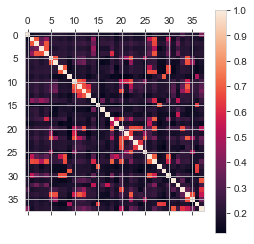

In [7]:
%pylab inline
matshow(adjacencyMatrix(conj_mean_prob_graph).toarray())
colorbar()

## Testing shortest-path mapping from a source region



In [8]:
raw_scores, scores, path_lengths, backprop = mat_vox_graph.shortest_path_map("cst_seed.nii.gz")
mat_vox_graph.save_nifti(raw_scores, "raw_scores.nii.gz")
mat_vox_graph.save_nifti(backprop, "backprop.nii.gz")

INFO:mittens.spatial:Loading NIfTI Image cst_seed.nii.gz
INFO:mittens.spatial:Loading NIfTI Image cst_seed.nii.gz
INFO:mittens.voxel_graph:Computed shortest paths in 0.11079 sec


Visualizing one of the backprop maps,

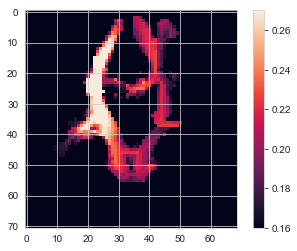

In [9]:
import nibabel as nb
bp_data = nb.load("backprop.nii.gz").get_fdata()
imshow(bp_data[:,40,::-1].T, vmin=.16, vmax=0.27)
colorbar()